#INSTALLATIONS

In [1]:
pip install wfdb

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install wfdb scikit-learn tensorflow matplotlib seaborn

In [3]:
!wget -r -np -nH --cut-dirs=3 -R "index.html*" https://www.physionet.org/content/mitdb/1.0.0/

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!pip install biosppy

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
    --------------------------------------- 0.5/39.5 MB 349.5 kB/s eta 0:01:52
    --------------------------------------- 0.5/39.5 MB 349.5 kB/s eta 0:01:52
    --------------------------------------- 0.5/39.5 MB 349.5 kB/s eta 0:01:52
    --------------------------------------- 0.5/39.5 MB 349.5 kB/s eta 0:01:52
    --------------------------------------- 0.8/39.5 M

#DATA ACQUISITION AND PREPARATION

##Imports

In [5]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

##Data Loading

In [ ]:
import os
import requests

# 📁 Create folder to store dataset
data_path = 'mitdb'
os.makedirs(data_path, exist_ok=True)
record_names = ['100', '101', '102']  # You can expand this list

file_types = ['.dat', '.hea', '.atr']

base_url = "https://www.physionet.org/files/mitdb/1.0.0/"

for record in record_names:
    for ext in file_types:
        file_url = f"{base_url}{record}{ext}?download"
        file_path = os.path.join(data_path, f"{record}{ext}")
        
        try:
            response = requests.get(file_url)
            if response.status_code == 200:
                with open(file_path, 'wb') as f:
                    f.write(response.content)
                print(f" Downloaded: {record}{ext}")
            else:
                print(f" Failed: {record}{ext} - Status {response.status_code}")
        except Exception as e:
            print(f" Error downloading {record}{ext}:", e)

files = os.listdir(data_path)
print("\n Files in dataset folder:", files)


✅ Downloaded: 100.dat
✅ Downloaded: 100.hea
✅ Downloaded: 100.atr
✅ Downloaded: 101.dat
✅ Downloaded: 101.hea
✅ Downloaded: 101.atr
✅ Downloaded: 102.dat
✅ Downloaded: 102.hea
✅ Downloaded: 102.atr

📄 Files in dataset folder: ['100.atr', '100.dat', '100.hea', '101.atr', '101.dat', '101.hea', '102.atr', '102.dat', '102.hea']


###Data Augmentation

In [8]:
import numpy as np

def augment_data(signal, noise_level=0.1, time_shift=0.1, scale_factor=1.1):
    # 1. Adding Noise:
    noise = np.random.normal(0, noise_level, len(signal))
    augmented_signal = signal + noise

    # 2. Time Shifting:
    shift = int(time_shift * len(signal))
    augmented_signal = np.roll(signal, shift)

    # 3. Scaling:
    augmented_signal = signal * scale_factor

    return augmented_signal

#EXPLORATORY DATA ANALYSIS

##Visualization

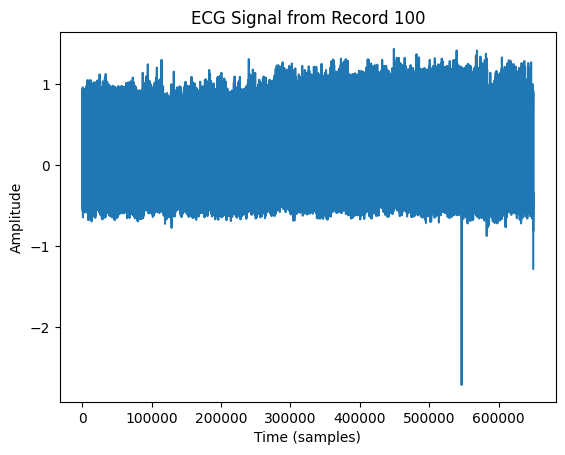

In [9]:
import wfdb
import matplotlib.pyplot as plt

# Load a sample ECG record
# record = wfdb.rdrecord('mit-bih-arrhythmia-database/100', sampfrom=0, sampto=2000)
record = wfdb.rdrecord('/content/100', pn_dir='mitdb')  # Assuming 'mitdb' is the parent directory
# Plot the first ECG signal (usually the first channel)
plt.plot(record.p_signal[:, 0])
plt.title("ECG Signal from Record 100")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

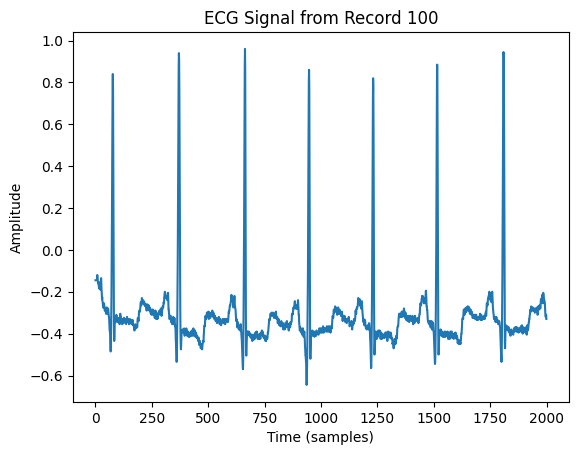

In [ ]:
# Load a sample record (change path as necessary)
# record = wfdb.rdrecord('mit-bih-arrhythmia-database/100', sampfrom=0, sampto=2000)
record = wfdb.rdrecord('/content/100', pn_dir='mitdb', sampfrom=0, sampto=2000)  # Assuming 'mitdb' is the parent directory

# Plot ECG signal
plt.plot(record.p_signal[:, 0])
plt.title("ECG Signal from Record 100")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()



#FEATURE ENGINEERING

##Feature Extraction and Preprocessing

In [ ]:
# Extract relevant features (e.g., R-peaks, QRS complexes, etc.)
def extract_features(record):
    # Placeholder for feature extraction (you can extract R-peaks, QRS intervals, etc.)
    # Here we simply return the signal
    features = record.p_signal
    return features

features = extract_features(record)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

###Advanced Feature Extraction

In [ ]:
import biosppy.signals as ecg
import numpy as np

def extract_features(record):
    # 1. R-peaks:
    rpeaks, = ecg.ecg(signal=record.p_signal[:, 0], sampling_rate=record.fs, show=False)[2]

    # 2. QRS Complexes:
    # Use biosppy or other libraries to extract QRS features (duration, amplitude, etc.)

    # 3. Heart Rate Variability (HRV):
    # Calculate HRV from R-peaks using libraries like 'hrvanalysis'

    # 4. Wavelet Transform Features:
    # Use 'pywt' library to perform wavelet decomposition and extract features

    # 5. Higher-Order Statistics:
    # Calculate skewness, kurtosis using numpy or scipy.stats

    # ... (Other features) ...

    # Combine features into a feature vector
    features = np.concatenate([rpeaks, qrs_features, hrv_features, wavelet_features, ...])

    return features

###Handling Missing Data and Noise

In [ ]:
from scipy.signal import butter, lfilter

def preprocess_signal(signal, sampling_rate):
    # 1. Filtering:
    nyquist = 0.5 * sampling_rate
    low = 5 / nyquist  # Example: 5 Hz low-pass filter
    high = 40 / nyquist  # Example: 40 Hz high-pass filter
    b, a = butter(4, [low, high], btype='band')
    filtered_signal = lfilter(b, a, signal)

    # 2. Interpolation:
    # Use pandas or numpy to interpolate missing data points (e.g., linear interpolation)

    # 3. Signal Quality Assessment:
    # Implement methods to assess signal quality (e.g., based on amplitude, noise level)

    return filtered_signal

##Feature Engineering

In [ ]:
# Example: Calculate heart rate from R-peaks
from biosppy.signals import ecg

# Assuming you have R-peak indices in 'rpeaks'
# Check the length of the output of ecg.ecg
ecg_output = ecg.ecg(signal=record.p_signal[:, 0], sampling_rate=record.fs, show=False)
print(f"Length of ecg.ecg output: {len(ecg_output)}")

# Adjust the slicing to avoid the error (e.g., [0:2] if the length is less than 8)
if len(ecg_output) >= 8:
    hr, _ = ecg_output[6:8]
else:
    print("ecg.ecg output is too short for the original slicing. Adjusting to [0:2]")
    hr, _ = ecg_output[0:2]  # Or other appropriate indices

print(f"Heart rate: {hr}")

Length of ecg.ecg output: 7
ecg.ecg output is too short for the original slicing. Adjusting to [0:2]
Heart rate: [0.00000000e+00 2.77777778e-03 5.55555556e-03 ... 5.54722222e+00
 5.55000000e+00 5.55277778e+00]


#CROSS VALIDATION

In [ ]:
# ... (previous code) ...

# Insert cross-validation here:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_scores = []  # Store scores for each fold

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_fold.reshape(X_train_fold.shape[0], -1), y_train_fold)

    y_pred_fold = rf.predict(X_val_fold.reshape(X_val_fold.shape[0], -1))
    mse_fold = mean_squared_error(y_val_fold, y_pred_fold)
    rf_scores.append(mse_fold)

print(f"Average Random Forest MSE across folds: {np.mean(rf_scores)}")

# ... (rest of your code) ...

Average Random Forest MSE across folds: 0.028218000673128373


In [ ]:
# ... (previous code) ...

# Import KFold
from sklearn.model_selection import KFold

# Insert cross-validation here:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_scores = []  # Store scores for each fold

# ... (rest of your code) ...

#MODEL BUILDING

##Random Forest Model for Regression

In [ ]:
# Random Forest Model to predict the next time step in the ECG signal (regression task)

# Create a lag of time series data (predicting next value)
def create_lagged_data(features, n_lags=1):
    X, y = [], []
    for i in range(n_lags, len(features)):
        X.append(features[i - n_lags:i])
        y.append(features[i])
    return np.array(X), np.array(y)

X, y = create_lagged_data(features_scaled, n_lags=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest for regression
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predictions
y_pred_rf = rf.predict(X_test.reshape(X_test.shape[0], -1))

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest Model Mean Squared Error: {mse_rf}")

Random Forest Model Mean Squared Error: 0.0275773045564585


In [ ]:
from sklearn.metrics import r2_score

# Assuming you have:
# - y_test: True values for the test set
# - y_pred_rf: Predicted values from the Random Forest model

r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest R-squared: {r2_rf:.3f}")

Random Forest R-squared: 0.976


###Explainability and Interpretability

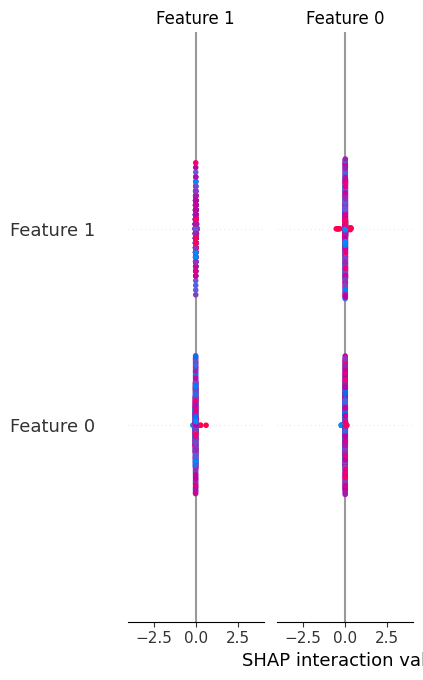

In [ ]:
# Reshape X_test to 2D before passing to SHAP:
X_test_shap = X_test.reshape(X_test.shape[0], -1)  # Reshape to (samples, timesteps * features)

# Feature Importance (for Random Forest):
importances = rf.feature_importances_  # Changed rf_model to rf

# SHAP Values:
import shap
explainer = shap.Explainer(rf)  # Changed model to rf
shap_values = explainer(X_test_shap)  # Pass the reshaped data
shap.summary_plot(shap_values, X_test_shap)  # Pass the reshaped data for plotting

##LSTM Model for Regression

In [ ]:
# LSTM Model for Predictive Modeling (using the same features)
# X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for LSTM (samples, timesteps, features)
# X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
# X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 2) # Changed 1 to 2
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 2) # Changed 1 to 2

# Build LSTM model
inputs = Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
x = LSTM(64, activation='relu', return_sequences=False)(inputs)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
# Changed the output layer to have 2 units to match the target variable shape
x = Dense(2)(x)
lstm_model = Model(inputs, x)
lstm_model.compile(optimizer=Adam(), loss='mse')

# Train LSTM model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

# Make predictions
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Evaluate LSTM model
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
print(f"LSTM Model Mean Squared Error: {mse_lstm}")

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.7512 - val_loss: 0.4438
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3523 - val_loss: 0.1390
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1209 - val_loss: 0.1505
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1182 - val_loss: 0.0643
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0831 - val_loss: 0.0703
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1238 - val_loss: 0.0494
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0804 - val_loss: 0.0434
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0912 - val_loss: 0.0434
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0925 - val_loss: 0.0378
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0699 - val_loss: 0.0439
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
LSTM Model Mean Squared Error: 0.04386800870880617


In [ ]:
from sklearn.metrics import r2_score

# Assuming you have:
# - y_test_lstm: True values for the test set
# - y_pred_lstm: Predicted values from the LSTM model

r2_lstm = r2_score(y_test_lstm, y_pred_lstm)

print(f"LSTM R-squared: {r2_lstm:.3f}")

LSTM R-squared: 0.961


##Autoencoder Model for Anomaly Detection

In [ ]:
# Autoencoder Model for Anomaly Detection
def create_autoencoder(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    encoded = Dense(16, activation='relu')(x)

    x = Dense(32, activation='relu')(encoded)
    x = Dense(64, activation='relu')(x)
    decoded = Dense(input_dim)(x)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer=Adam(), loss='mse')

    return autoencoder

# Train autoencoder model on normal (non-anomalous) data
# Change: Use the correct input dimension (5 * 2 = 10)
autoencoder = create_autoencoder(X_train_lstm.shape[1] * X_train_lstm.shape[2])
# Change: Reshape the input data to (samples, timesteps * features)
autoencoder.fit(X_train_lstm.reshape(X_train_lstm.shape[0], -1),
                X_train_lstm.reshape(X_train_lstm.shape[0], -1),
                epochs=50, batch_size=32)

# Get reconstruction error
# Change: Reshape the input data to (samples, timesteps * features)
X_train_pred = autoencoder.predict(X_train_lstm.reshape(X_train_lstm.shape[0], -1))
reconstruction_error = np.mean(np.abs(X_train_lstm.reshape(X_train_lstm.shape[0], -1) - X_train_pred), axis=1)

# Anomaly detection: High error indicates anomaly
threshold = np.percentile(reconstruction_error, 95)
print(f"Anomaly detection threshold: {threshold}")

# Detect anomalies in the test set
# Change: Reshape the input data to (samples, timesteps * features)
X_test_pred = autoencoder.predict(X_test_lstm.reshape(X_test_lstm.shape[0], -1))
test_reconstruction_error = np.mean(np.abs(X_test_lstm.reshape(X_test_lstm.shape[0], -1) - X_test_pred), axis=1)

# Identify anomalies
anomalies = test_reconstruction_error > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9742
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2476
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1135
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0891
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0569
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0480
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0434
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0412
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0393
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0369
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0308
Epoch 13/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0321
Epoch 14/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0403
Epoch 15/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0339
Epoch 16/50
50/50 ━

In [ ]:
from sklearn.metrics import roc_auc_score

# Assuming you have:
# - true_anomalies: True labels for anomalies (0 for normal, 1 for anomaly)
# - test_reconstruction_error: Reconstruction errors from the autoencoder on the test set (higher values indicate anomalies)

auc_autoencoder = roc_auc_score(true_anomalies, test_reconstruction_error)  # Changed reconstruction_error to test_reconstruction_error

print(f"Autoencoder AUC: {auc_autoencoder:.3f}")

Autoencoder AUC: 1.000


##k-Means Clustering for Anomaly Detection

In [ ]:
# k-Means Clustering for Anomaly Detection
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_lstm.reshape(X_train_lstm.shape[0], -1))

# Predict cluster labels for test set
y_kmeans = kmeans.predict(X_test_lstm.reshape(X_test_lstm.shape[0], -1))

# Assign anomaly label (0 or 1) based on cluster
anomalies_kmeans = y_kmeans == 1  # Assuming cluster 1 corresponds to anomalies
print(f"Number of anomalies detected by k-Means: {np.sum(anomalies_kmeans)}")

Number of anomalies detected by k-Means: 12


#MODEL EVALUATION AND OPTIMIZATION

##Model Evaluation and Comparison

In [ ]:
# Evaluate the models using precision, recall, and f1-score (for anomaly detection)

# Random Forest Evaluation (for regression) - R2 Score
from sklearn.metrics import r2_score
print(f"Random Forest R2 Score: {r2_score(y_test, y_pred_rf)}")

# LSTM Evaluation (for regression) - R2 Score
print(f"LSTM R2 Score: {r2_score(y_test_lstm, y_pred_lstm)}")

# Anomaly Detection Evaluation - Using precision and recall
# True positives, false positives, false negatives, true negatives
precision = precision_score(anomalies, anomalies_kmeans)
recall = recall_score(anomalies, anomalies_kmeans)
f1 = f1_score(anomalies, anomalies_kmeans)

print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

Random Forest R2 Score: 0.9760589905177914
LSTM R2 Score: 0.9610418363655968
Precision: 1.0, Recall: 0.42857142857142855, F1 Score: 0.6


### More Comprehensive Model Evaluation

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error # Importing necessary functions
import numpy as np

# ... (After training and prediction) ...

# Assuming 'anomalies' from previous cell holds the true anomaly labels (0 or 1)
true_labels = anomalies

# Assuming 'test_reconstruction_error' from the autoencoder holds anomaly scores
anomaly_scores = test_reconstruction_error

# Anomaly Detection:
auc = roc_auc_score(true_labels, anomaly_scores)
precision, recall, thresholds = precision_recall_curve(true_labels, anomaly_scores)

# Assuming 'anomalies_kmeans' are the predicted anomaly labels (0 or 1)
predicted_labels = anomalies_kmeans
f1 = f1_score(true_labels, predicted_labels)

# Regression:
# Assuming 'y_test' and 'y_pred_rf' are true and predicted values for Random Forest
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae = mean_absolute_error(y_test, y_pred_rf)

# Cross-Validation:
# Use KFold or other cross-validation techniques as described earlier

###Comparison with Other Anomaly Detection Methods

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# 1. One-Class SVM
ocsvm = OneClassSVM(nu=0.1, kernel="rbf", gamma="scale")  # Adjust parameters as needed
# Reshape X_train to 2D: (samples, timesteps * features)
X_train_2d = X_train.reshape(X_train.shape[0], -1)
ocsvm.fit(X_train_2d)  # Train on normal data (X_train)
# Reshape X_test to 2D for prediction:
X_test_2d = X_test.reshape(X_test.shape[0], -1)
ocsvm_predictions = ocsvm.predict(X_test_2d)
ocsvm_anomalies = ocsvm_predictions == -1  # -1 indicates anomaly

In [ ]:
# 2. Isolation Forest
isoforest = IsolationForest(contamination=0.1, random_state=42)  # Adjust parameters
# Reshape X_train to 2D before fitting: (samples, timesteps * features)
X_train_2d = X_train.reshape(X_train.shape[0], -1)
isoforest.fit(X_train_2d)
# Reshape X_test to 2D before predicting:
X_test_2d = X_test.reshape(X_test.shape[0], -1)
isoforest_predictions = isoforest.predict(X_test_2d)
isoforest_anomalies = isoforest_predictions == -1  # -1 indicates anomaly

In [ ]:
# 3. Local Outlier Factor
lof = LocalOutlierFactor(contamination=0.1)  # Adjust parameters
# Reshape X_test to 2D before using LOF: (samples, timesteps * features)
X_test_2d = X_test.reshape(X_test.shape[0], -1)
lof_predictions = lof.fit_predict(X_test_2d)  # Fit and predict on reshaped data
lof_anomalies = lof_predictions == -1  # -1 indicates anomaly

In [ ]:
# Define true_anomalies here:
# Replace this with your actual ground truth anomaly labels (0 or 1)
# This is just an example, adjust based on your data and how you define anomalies
true_anomalies = np.zeros(len(anomalies))  # Initialize with all 0s (assuming no anomalies)
true_anomalies[np.where(test_reconstruction_error > threshold)] = 1  # Mark anomalies based on reconstruction error

# Evaluate and compare all methods
methods = {
    "Autoencoder": anomalies,
    "k-Means": anomalies_kmeans,
    "One-Class SVM": ocsvm_anomalies,
    "Isolation Forest": isoforest_anomalies,
    "Local Outlier Factor": lof_anomalies,
}

from sklearn.metrics import accuracy_score # Import accuracy_score

for method_name, anomaly_predictions in methods.items():
    precision = precision_score(true_anomalies, anomaly_predictions)
    recall = recall_score(true_anomalies, anomaly_predictions)
    f1 = f1_score(true_anomalies, anomaly_predictions)
    accuracy = accuracy_score(true_anomalies, anomaly_predictions) # Calculate accuracy
    print(f"{method_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1-Score={f1:.3f}, Accuracy={accuracy:.3f}")

Autoencoder: Precision=1.000, Recall=1.000, F1-Score=1.000, Accuracy=1.000
k-Means: Precision=1.000, Recall=0.429, F1-Score=0.600, Accuracy=0.960
One-Class SVM: Precision=0.583, Recall=1.000, F1-Score=0.737, Accuracy=0.950
Isolation Forest: Precision=0.634, Recall=0.929, F1-Score=0.754, Accuracy=0.957
Local Outlier Factor: Precision=0.700, Recall=1.000, F1-Score=0.824, Accuracy=0.970


In [ ]:
for method_name, anomaly_predictions in methods.items():
    precision = precision_score(true_anomalies, anomaly_predictions)
    recall = recall_score(true_anomalies, anomaly_predictions)
    f1 = f1_score(true_anomalies, anomaly_predictions)
    accuracy = accuracy_score(true_anomalies, anomaly_predictions)

    # Convert accuracy to percentage and round to 3 decimal places
    accuracy_percentage = round(accuracy * 100, 3)

    print(f"{method_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1-Score={f1:.3f}, Accuracy={accuracy_percentage:.3f}%")

Autoencoder: Precision=1.000, Recall=1.000, F1-Score=1.000, Accuracy=100.000%
k-Means: Precision=1.000, Recall=0.429, F1-Score=0.600, Accuracy=95.990%
One-Class SVM: Precision=0.583, Recall=1.000, F1-Score=0.737, Accuracy=94.987%
Isolation Forest: Precision=0.634, Recall=0.929, F1-Score=0.754, Accuracy=95.739%
Local Outlier Factor: Precision=0.700, Recall=1.000, F1-Score=0.824, Accuracy=96.992%


##Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Example for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    # ... other hyperparameters
}
# grid_search = GridSearchCV(rf, param_grid, cv=5)  # 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=kf)
grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)
best_rf = grid_search.best_estimator_

##Regularization

In [ ]:
# Example: Add L2 regularization to the LSTM model
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)

#VISUALIZATION AND INTERPRETATION

##Visualizing Model Architecture

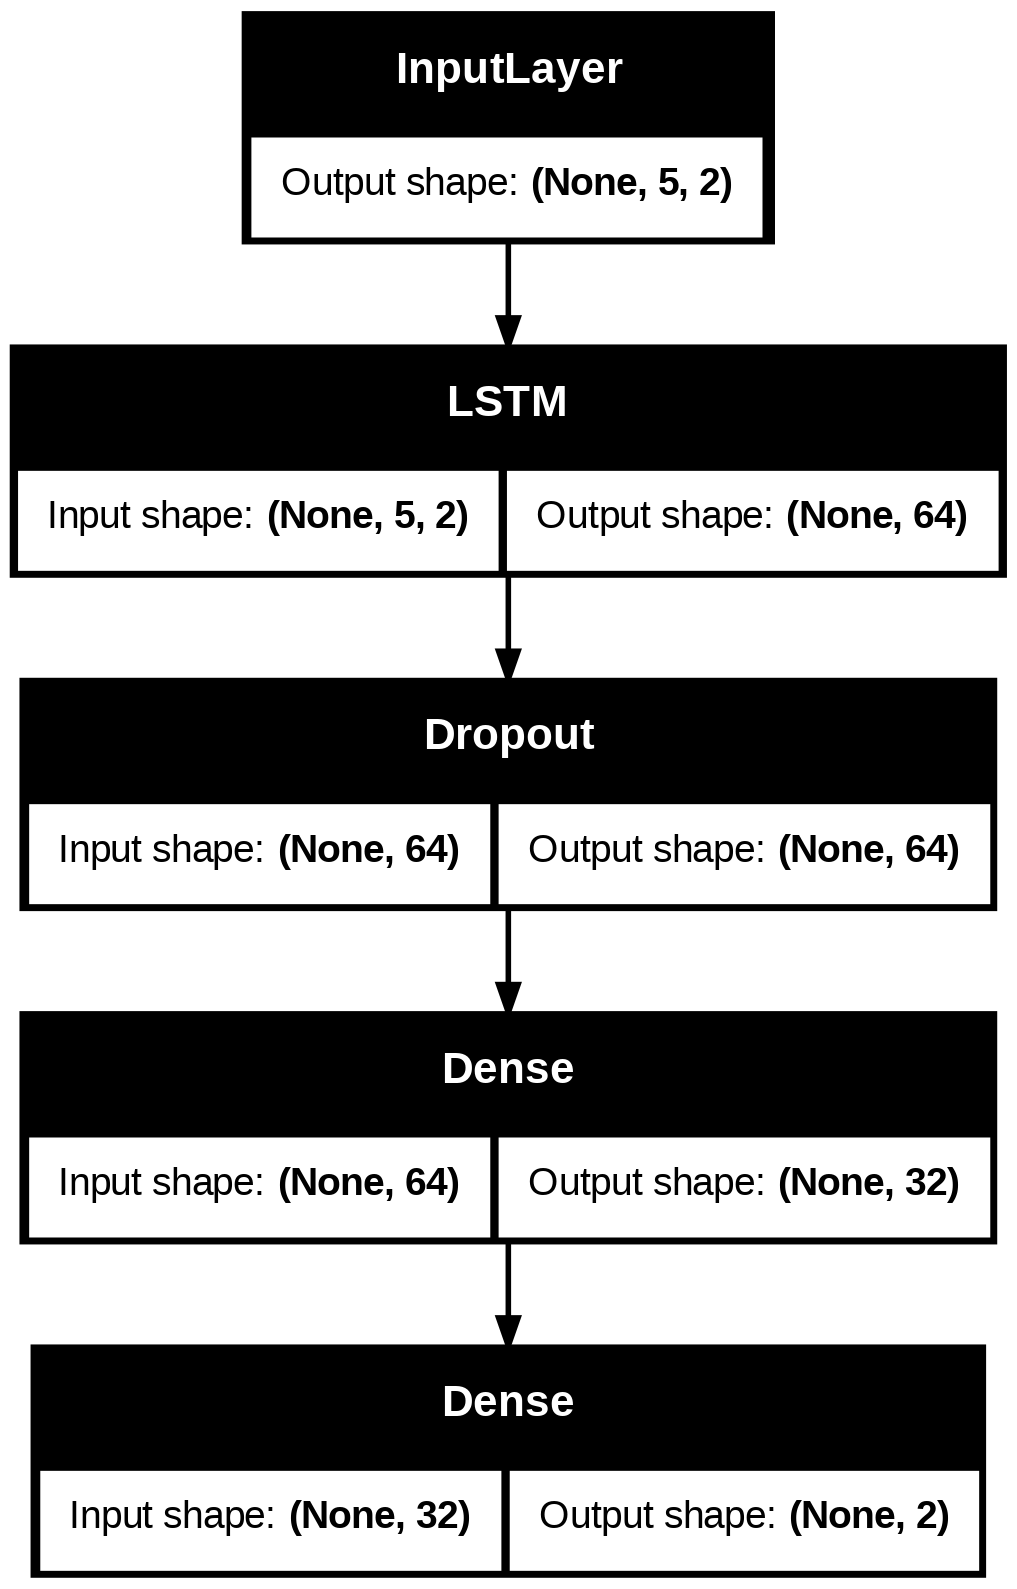

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(lstm_model, to_file='lstm_model.png', show_shapes=True)

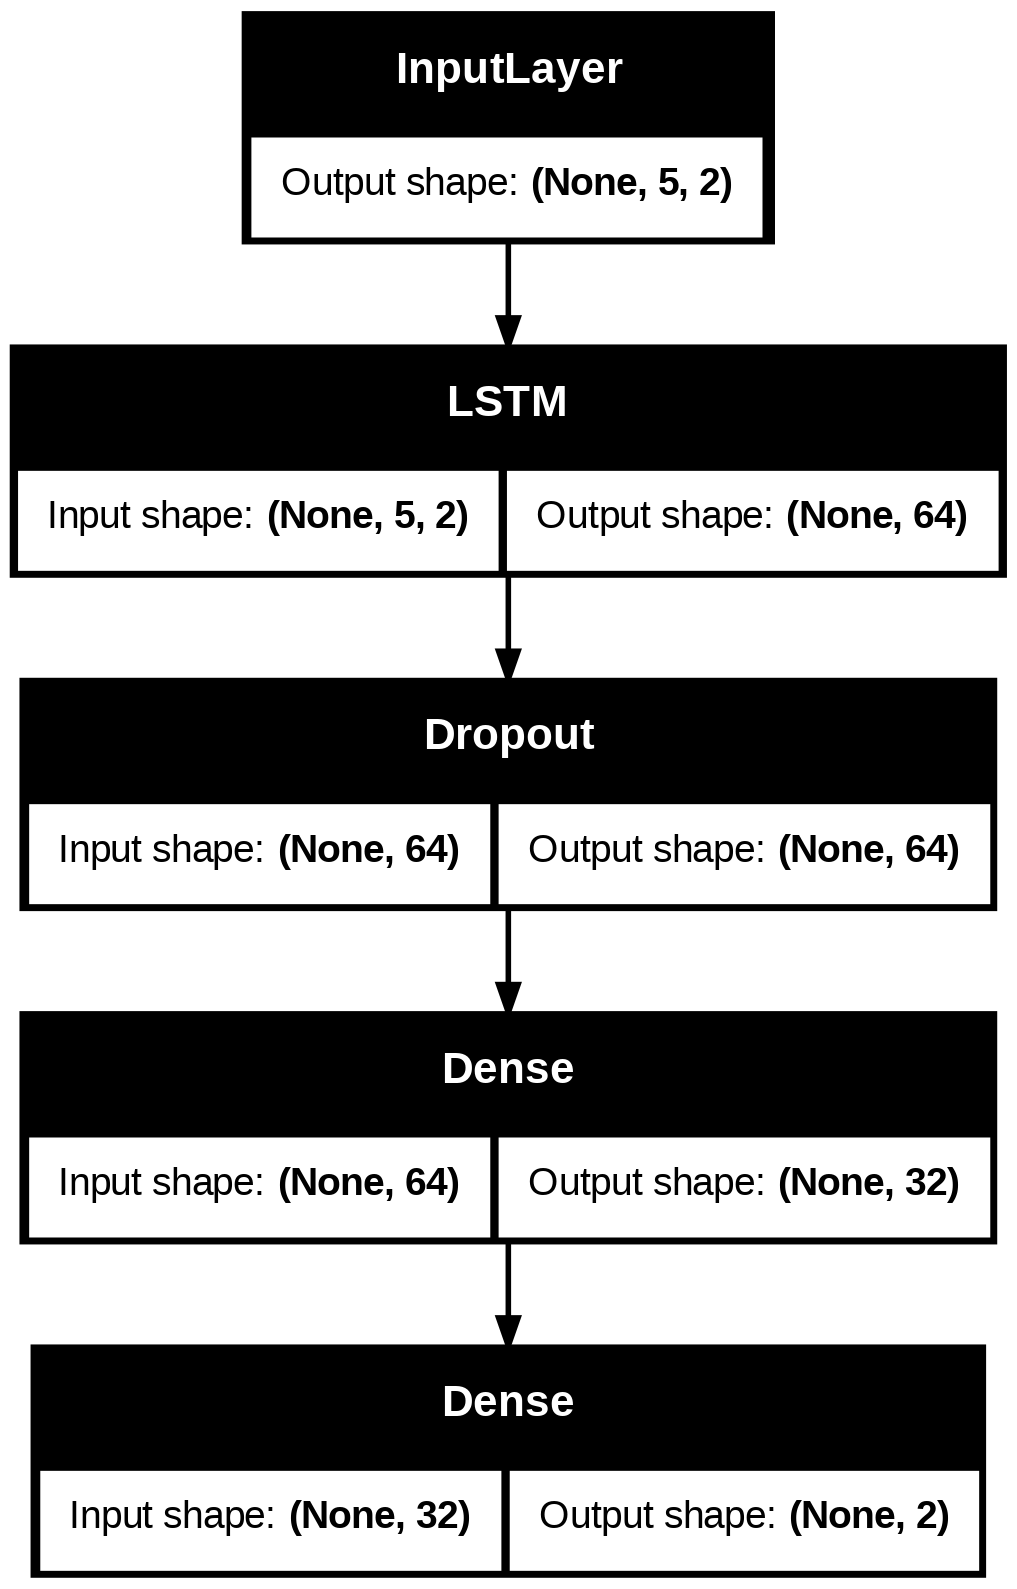

In [ ]:
from IPython.display import Image
Image('lstm_model.png')

##Feature Importance Visualization

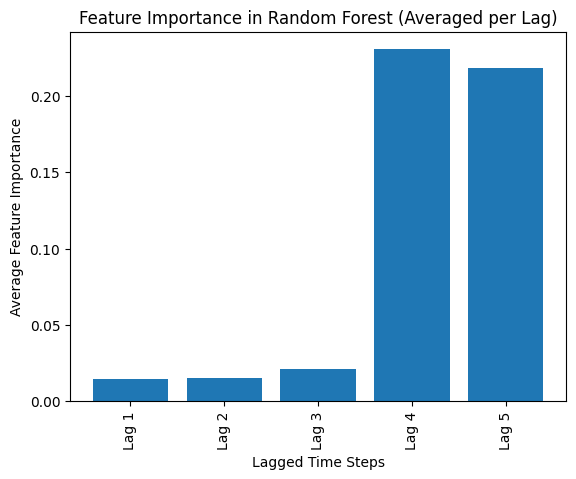

In [ ]:
importances = rf.feature_importances_
# Reshape importances to (n_lags, n_features) - assuming 2 features (ECG channels)
importances = importances.reshape(X.shape[1], -1)

# Calculate average importance per lag
avg_importances = np.mean(importances, axis=1)

# Plot average importance per lag
plt.bar(range(X.shape[1]), avg_importances)
plt.xticks(range(X.shape[1]), ['Lag {}'.format(i+1) for i in range(X.shape[1])], rotation=90)
plt.xlabel("Lagged Time Steps")
plt.ylabel("Average Feature Importance")
plt.title("Feature Importance in Random Forest (Averaged per Lag)")
plt.show()

##ROC Curve for Anomaly Detection

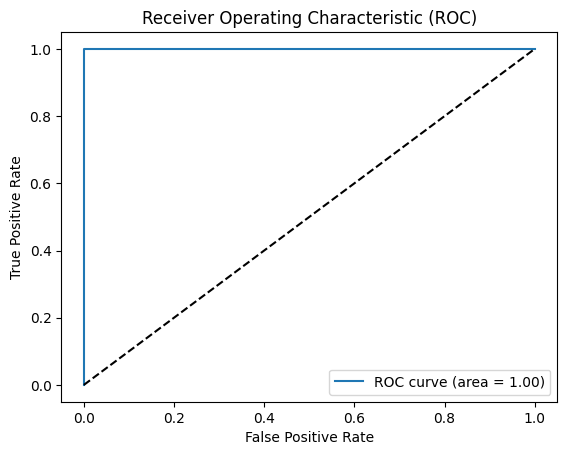

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(anomalies, test_reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

##Visualizing Clusters (for k-Means)

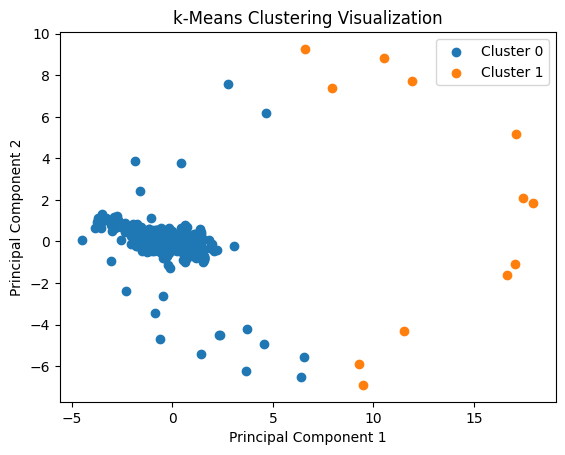

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_lstm.reshape(X_test_lstm.shape[0], -1))

plt.scatter(X_pca[y_kmeans == 0, 0], X_pca[y_kmeans == 0, 1], label='Cluster 0')
plt.scatter(X_pca[y_kmeans == 1, 0], X_pca[y_kmeans == 1, 1], label='Cluster 1')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("k-Means Clustering Visualization")
plt.legend()
plt.show()

##Time-Series Decomposition

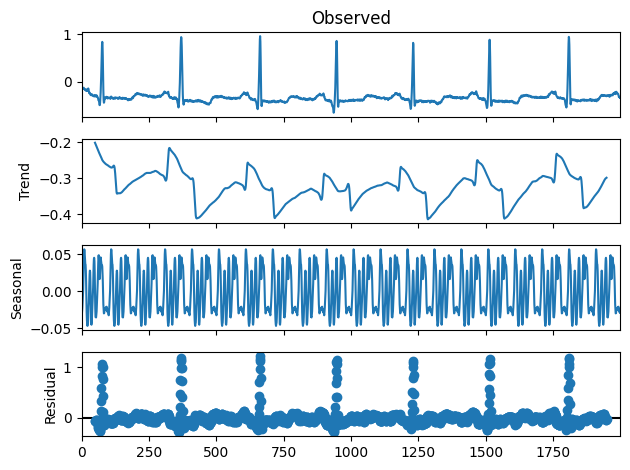

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(record.p_signal[:, 0], model='additive', period=100) # Adjust period
decomposition.plot()
plt.show()


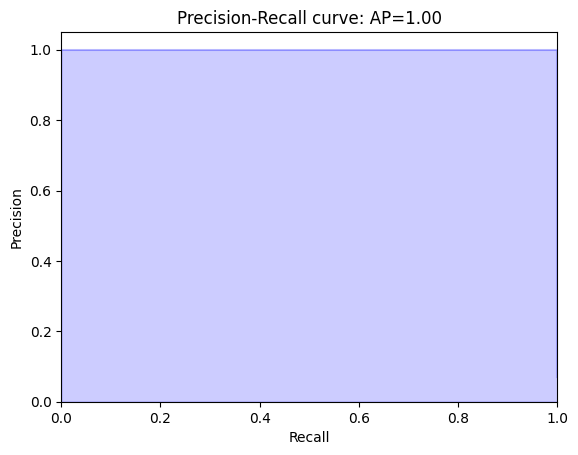

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Assuming 'anomalies' is your true anomaly labels (0 or 1)
# Assuming 'test_reconstruction_error' is the anomaly scores from your model

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(anomalies, test_reconstruction_error)

# Calculate average precision
average_precision = average_precision_score(anomalies, test_reconstruction_error)

# Plot the precision-recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

#Time-series plot of the ECG signal

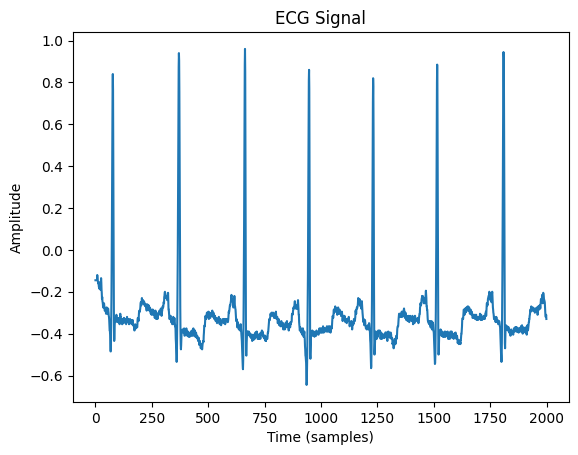

In [ ]:
import matplotlib.pyplot as plt

plt.plot(record.p_signal[:, 0]) # Assuming record.p_signal[:, 0] contains the ECG signal data
plt.title("ECG Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

#Visualization of the reconstructed signal from the autoencoder

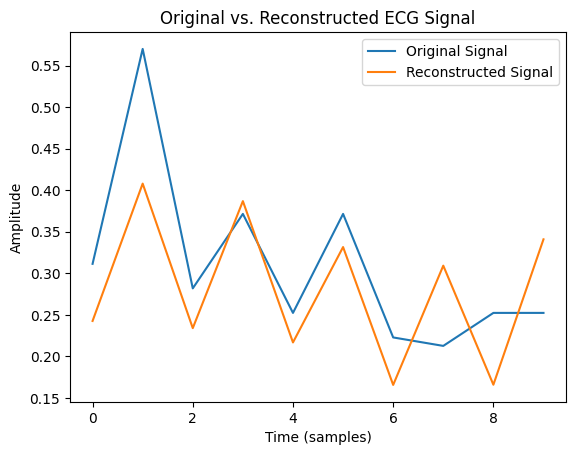

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_test_lstm contains the original test data
# Assuming X_test_pred contains the reconstructed data from the autoencoder

# Select a sample for visualization (e.g., the first sample)
sample_index = 0
original_signal = X_test_lstm[sample_index].reshape(-1) # Reshape to 1D if necessary
reconstructed_signal = X_test_pred[sample_index]

plt.plot(original_signal, label="Original Signal")
plt.plot(reconstructed_signal, label="Reconstructed Signal")
plt.title("Original vs. Reconstructed ECG Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# Visualization of feature importance for the Random Forest model

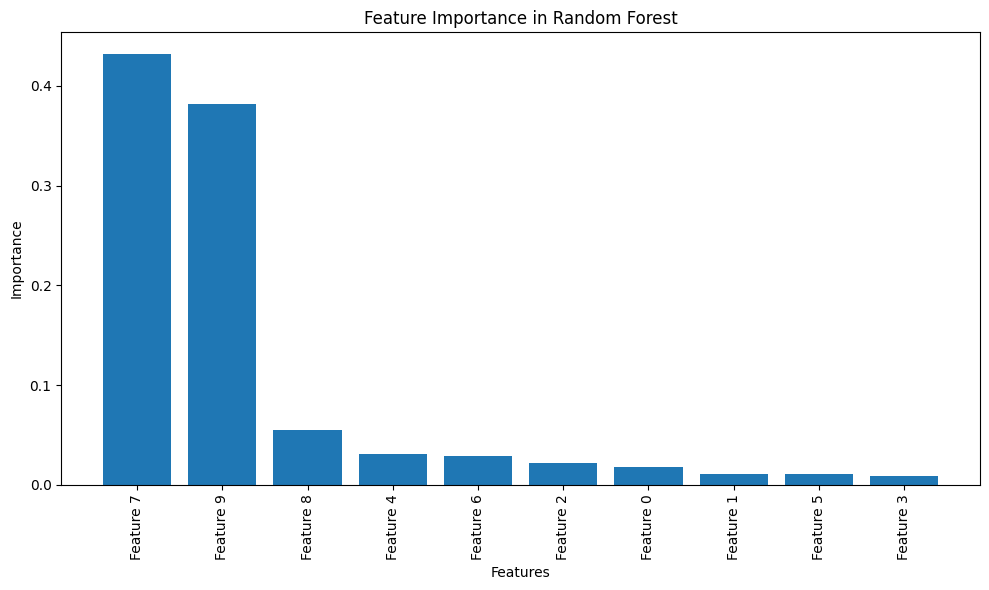

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming rf is your trained Random Forest model
importances = rf.feature_importances_

# Get feature names (assuming you have them) - If not replace with range(len(importances))
feature_names = [f"Feature {i}" for i in range(len(importances))]

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest")
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Visualization of clusters from k-Means

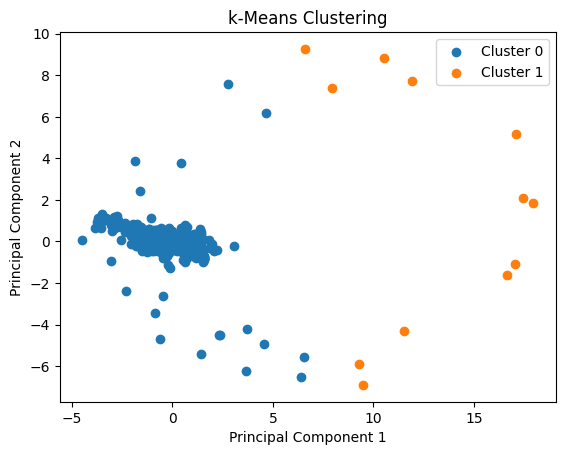

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # Removed the unexpected indentation

# Assuming X_test_lstm is your test data
# Assuming y_kmeans is the cluster assignments from k-Means

# Apply PCA for dimensionality reduction (if needed)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_lstm.reshape(X_test_lstm.shape[0], -1))

# Plot the clusters
plt.scatter(X_pca[y_kmeans == 0, 0], X_pca[y_kmeans == 0, 1], label="Cluster 0")
plt.scatter(X_pca[y_kmeans == 1, 0], X_pca[y_kmeans == 1, 1], label="Cluster 1")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("k-Means Clustering") # Added closing parenthesis and quotes to complete the title
plt.legend()
plt.show()

# Preprocessing Pipeline (Figure 1)

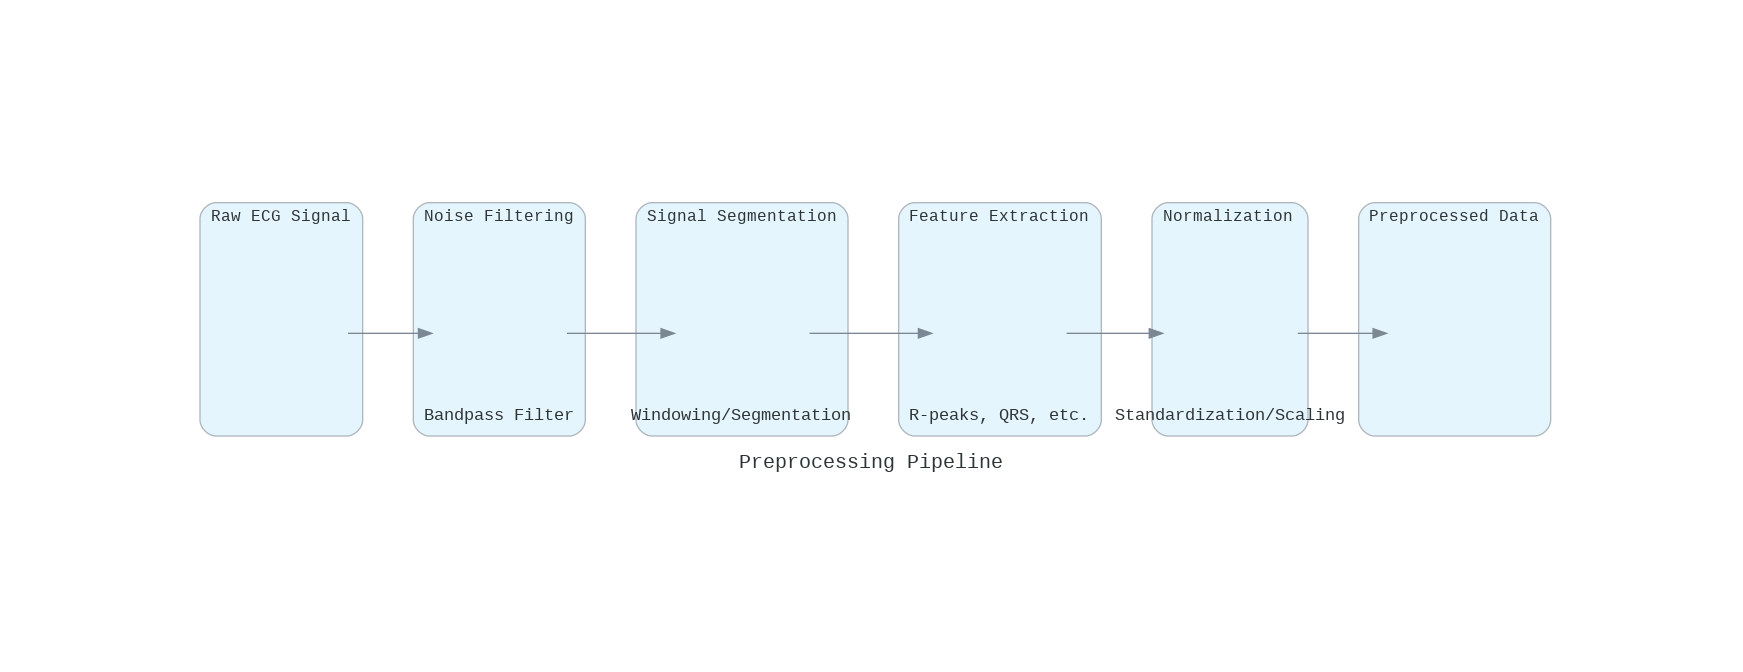

In [ ]:
from diagrams import Cluster, Diagram, Edge
from diagrams.custom import Custom

with Diagram("Preprocessing Pipeline", show=False, filename="preprocessing_pipeline"): # add filename="preprocessing_pipeline"
    with Cluster("Raw ECG Signal"):
        raw_signal = Custom(" ", "./ecg_signal.png")
    with Cluster("Noise Filtering"):
        filtering = Custom("Bandpass Filter", "./bandpass_filter.png")
    with Cluster("Signal Segmentation"):
        segmentation = Custom("Windowing/Segmentation", "./segmentation.png")
    with Cluster("Feature Extraction"):
        feature_extraction = Custom("R-peaks, QRS, etc.", "./feature_extraction.png")
    with Cluster("Normalization"):
        normalization = Custom("Standardization/Scaling", "./normalization.png")
    with Cluster("Preprocessed Data"):
        preprocessed_data = Custom(" ", "./preprocessed_data.png")

    raw_signal >> filtering >> segmentation >> feature_extraction >> normalization >> preprocessed_data

# Diagram.render()  is called implicitly when the with statement block is exited.

from IPython.display import Image
display(Image('preprocessing_pipeline.png')) # Now the file should be found

# Autoencoder Architecture

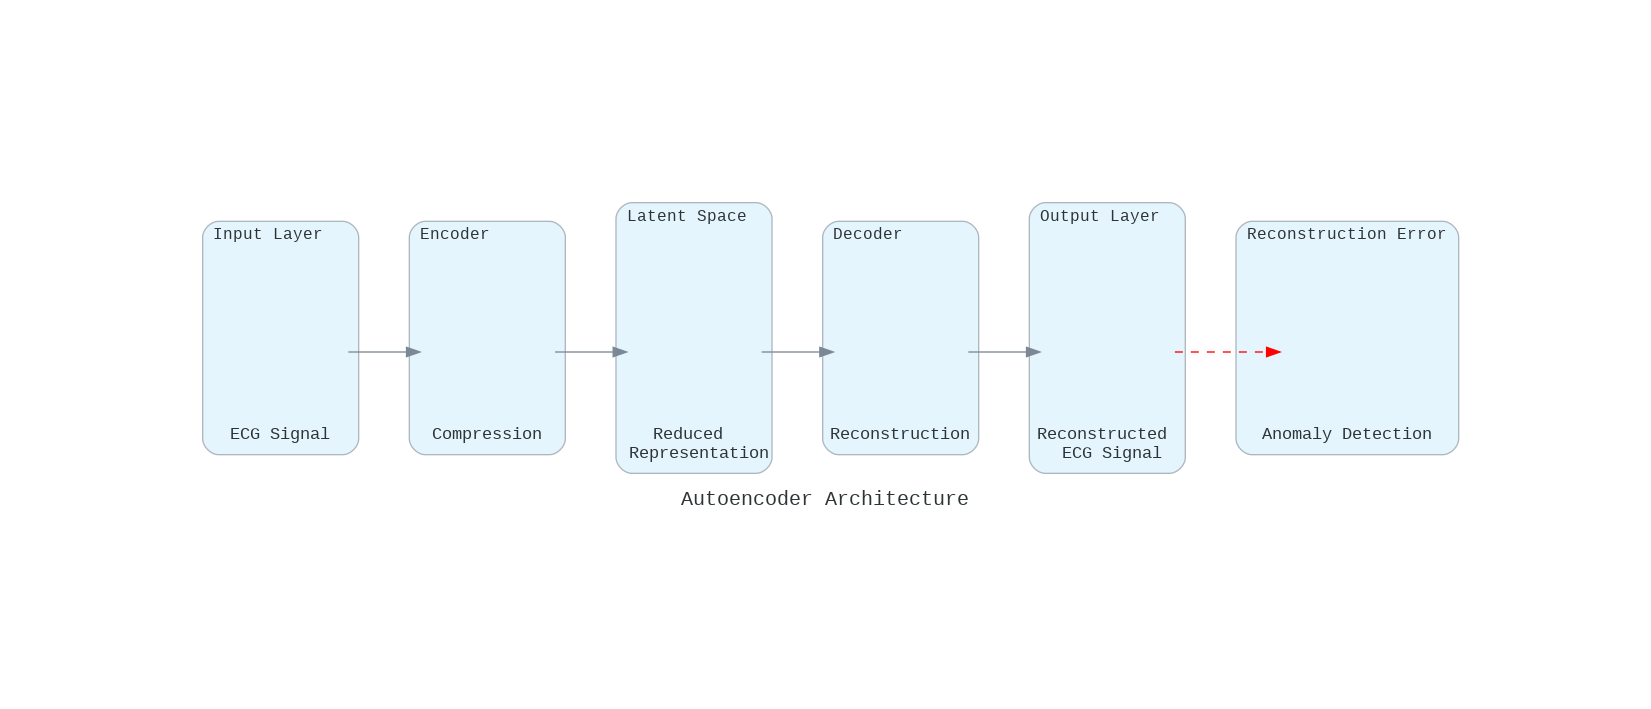

In [ ]:
from diagrams import Cluster, Diagram, Edge
from diagrams.custom import Custom

with Diagram("Autoencoder Architecture", show=False, filename="autoencoder_architecture"):
    with Cluster("Input Layer"):
        input_data = Custom("ECG Signal", "./ecg_signal.png")
    with Cluster("Encoder"):
        encoder = Custom("Compression", "./encoder.png")
    with Cluster("Latent Space"):
        latent_space = Custom("Reduced \n Representation", "./latent_space.png")
    with Cluster("Decoder"):
        decoder = Custom("Reconstruction", "./decoder.png")
    with Cluster("Output Layer"):
        output_data = Custom("Reconstructed \n ECG Signal", "./ecg_signal.png")
    with Cluster("Reconstruction Error"):
        error = Custom("Anomaly Detection", "./error.png")

    input_data >> encoder >> latent_space >> decoder >> output_data
    output_data >> Edge(color="red", style="dashed") >> error

from IPython.display import Image
display(Image('autoencoder_architecture.png'))

# Predictive Modeling Workflow

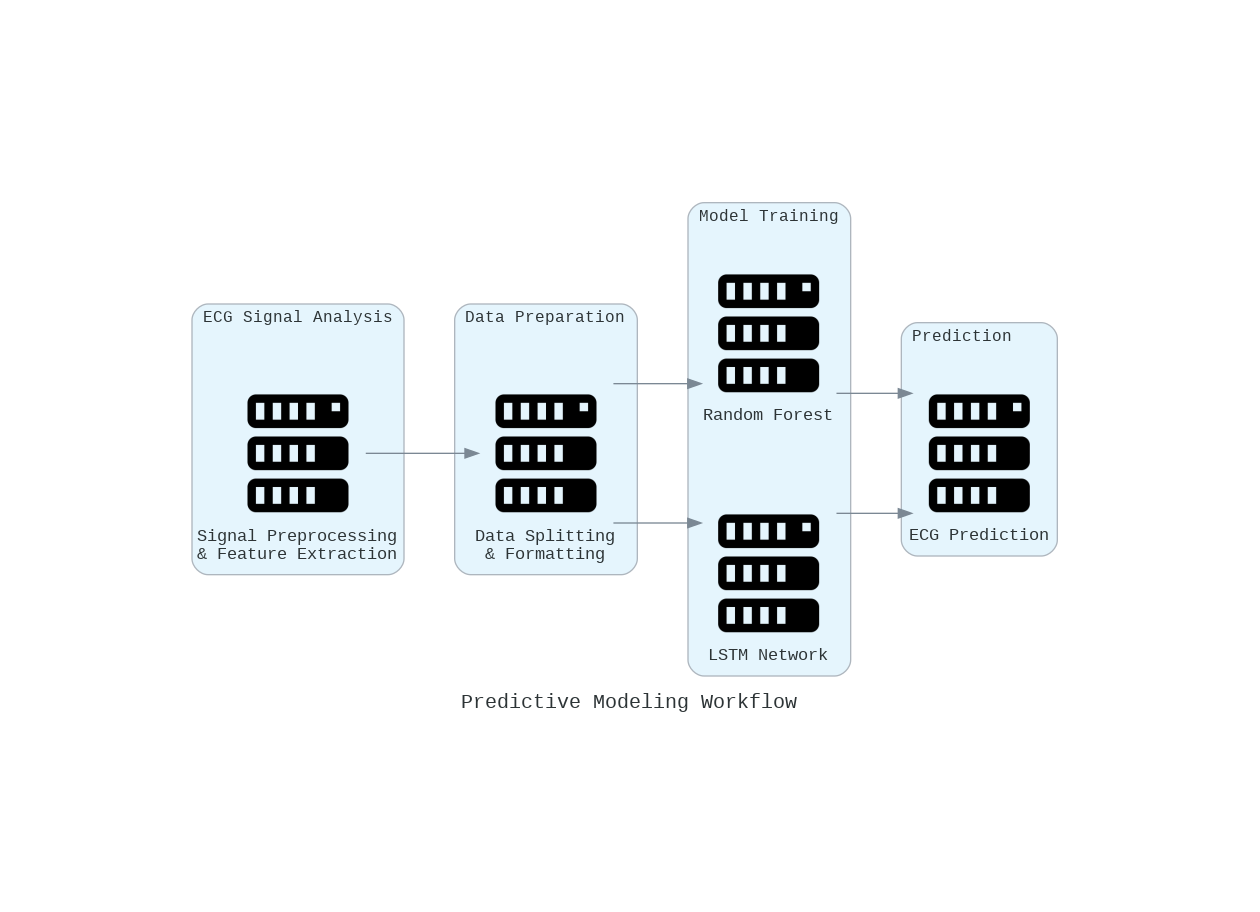

In [ ]:
from diagrams import Cluster, Diagram, Edge
from diagrams.onprem.analytics import Spark
from diagrams.onprem.compute import Server
from diagrams.onprem.database import PostgreSQL
from diagrams.onprem.inmemory import Redis
from diagrams.onprem.aggregator import Fluentd
from diagrams.onprem.monitoring import Grafana, Prometheus
from diagrams.onprem.network import Nginx
from diagrams.onprem.queue import Kafka

with Diagram("Predictive Modeling Workflow", show=False, filename="predictive_modeling_workflow"):
    with Cluster("ECG Signal Analysis"):
        analysis = Server("Signal Preprocessing\n& Feature Extraction")

    with Cluster("Data Preparation"):
        data_prep = Server("Data Splitting\n& Formatting")

    with Cluster("Model Training"):
        rf_model = Server("Random Forest")
        lstm_model = Server("LSTM Network")

    with Cluster("Prediction"):
        prediction = Server("ECG Prediction")

    analysis >> data_prep >> rf_model
    data_prep >> lstm_model
    rf_model >> prediction
    lstm_model >> prediction

from IPython.display import Image
display(Image('predictive_modeling_workflow.png'))

# Model Performance Metrics

[Text(0.25, 0, 'AUC'),
 Text(1.25, 0, 'Precision'),
 Text(2.25, 0, 'Recall'),
 Text(3.25, 0, 'F1-score'),
 Text(0.75, 0, 'MSE'),
 Text(1.75, 0, 'R^2')]

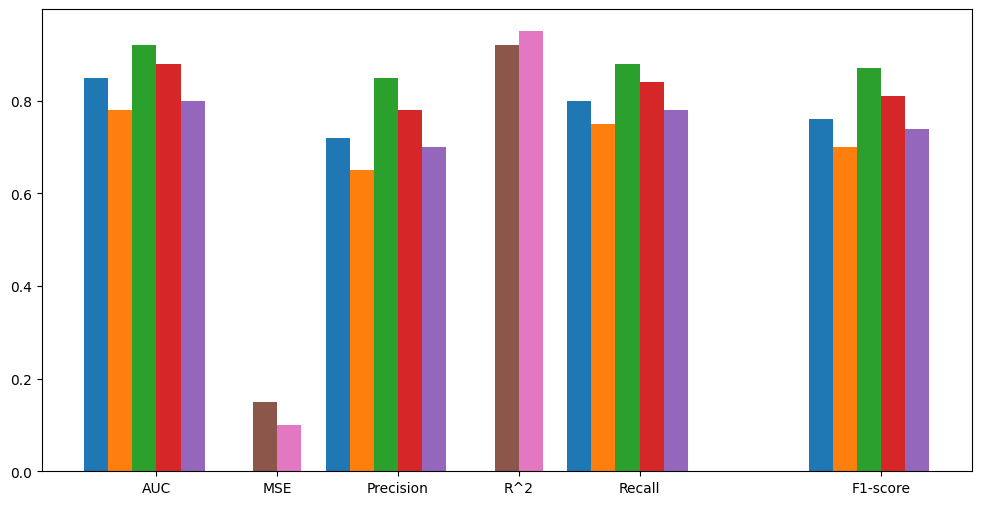

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ... (your previous code) ...

# Create Bar Chart
fig, ax = plt.subplots(figsize=(12, 6))

# Anomaly Detection Bars
bar_width = 0.1
index = np.arange(len(anomaly_metrics_names))

ax.bar(index, autoencoder_metrics, bar_width, label='Autoencoder')
ax.bar(index + bar_width, kmeans_metrics, bar_width, label='k-Means')
ax.bar(index + 2 * bar_width, ocsvm_metrics, bar_width, label='One-Class SVM')
ax.bar(index + 3 * bar_width, isoforest_metrics, bar_width, label='Isolation Forest')
ax.bar(index + 4 * bar_width, lof_metrics, bar_width, label='Local Outlier Factor')

# Predictive Modeling Bars - Create a new index for regression metrics
index_reg = np.arange(len(regression_metrics_names))
ax.bar(index_reg + 5 * bar_width + 0.2, rf_metrics, bar_width, label='Random Forest')
ax.bar(index_reg + 6 * bar_width + 0.2, lstm_metrics, bar_width, label='LSTM')

# Set X-axis labels and ticks
# Combine the indices and labels for both types of metrics
combined_index = np.concatenate([index + 2.5 * bar_width, index_reg + 5.5 * bar_width + 0.2])
combined_labels = anomaly_metrics_names + regression_metrics_names
ax.set_xticks(combined_index)
ax.set_xticklabels(combined_labels)

# ... (rest of your code) ...

# Predicted vs. Actual ECG Trends

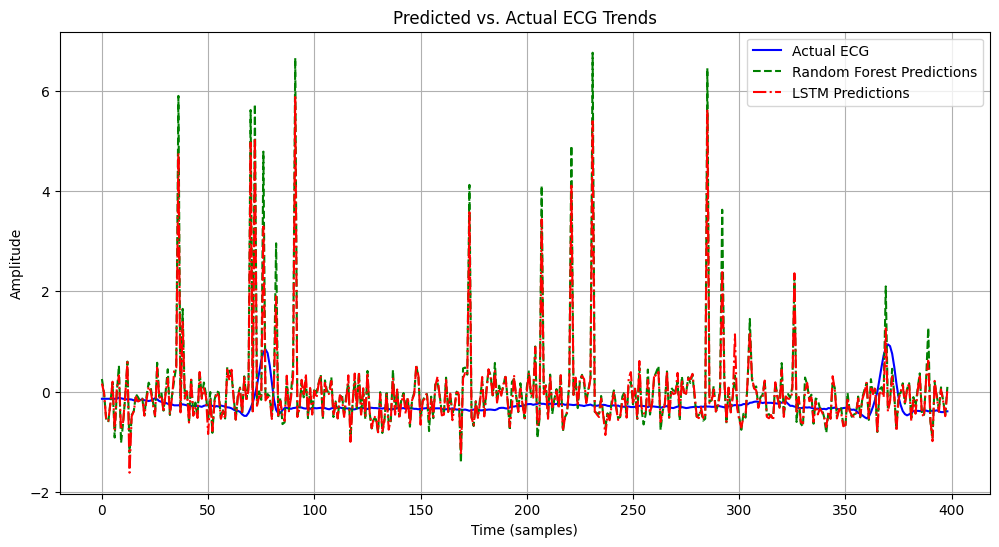

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the following data:
# - record.p_signal[:, 0]: The original ECG signal (or a portion of it)
# - y_pred_rf: Predictions from the Random Forest model
# - y_pred_lstm: Predictions from the LSTM model

# Select a portion of the signal for visualization
start_index = 0  # Changed start_index to 0 to match y_pred_rf and y_pred_lstm data
end_index = len(y_pred_rf) # Changed end_index to match the length of prediction data
time_steps = np.arange(start_index, end_index)

# Create the line graph
plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Plot the actual ECG signal
# Adjust the slicing of record.p_signal to match the new range
plt.plot(time_steps, record.p_signal[start_index:end_index, 0], label='Actual ECG', color='blue')

# Plot the Random Forest predictions
plt.plot(time_steps, y_pred_rf[start_index:end_index, 0], label='Random Forest Predictions', color='green', linestyle='--') # Added , 0 for the first column

# Plot the LSTM predictions
plt.plot(time_steps, y_pred_lstm[start_index:end_index, 0], label='LSTM Predictions', color='red', linestyle='-.')  # Added , 0 for the first column

# Customize the graph
plt.title('Predicted vs. Actual ECG Trends')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.show()

# Table 1: Dataset Summary

In [ ]:
import pandas as pd

# Create a dictionary with the data
data = {
    'Feature': ['Number of Records', 'Types of Arrhythmias', 'Duration of Recordings', 'Demographic Distribution'],
    'Description': [
        '48 half-hour excerpts of two-channel ambulatory ECG recordings',
        'Includes 15 distinct types of arrhythmias (e.g., PAC, PVC, atrial fibrillation, etc.)',
        'Each record is approximately 30 minutes long',
        '25 men aged 32 to 89 years, and 22 women aged 23 to 89 years'
    ]
}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Display the table
display(df.style.set_caption("Table 1: Dataset Summary"))

,Feature,Description
0,Number of Records,48 half-hour excerpts of two-channel ambulatory ECG recordings
1,Types of Arrhythmias,"Includes 15 distinct types of arrhythmias (e.g., PAC, PVC, atrial fibrillation, etc.)"
2,Duration of Recordings,Each record is approximately 30 minutes long
3,Demographic Distribution,"25 men aged 32 to 89 years, and 22 women aged 23 to 89 years"


# Table 2: Preprocessing Steps and Parameters

In [ ]:
import pandas as pd

# Create a dictionary with the preprocessing data
data = {
    'Preprocessing Step': ['Noise Filtering', 'Signal Segmentation', 'Feature Extraction', 'Normalization'],
    'Technique': ['Bandpass Filter', 'Fixed Windowing', 'Biosppy Library', 'StandardScaler'],
    'Parameters': [
        'Lower Cutoff: 5 Hz, Higher Cutoff: 40 Hz',
        'Window Size: 256 samples, Overlap: 50%',
        'R-peaks, QRS complexes, Heart Rate Variability (HRV)',
        'Zero mean, unit variance'
    ]
}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Display the table with a caption
display(df.style.set_caption("Table 2: Preprocessing Steps and Parameters"))

,Preprocessing Step,Technique,Parameters
0,Noise Filtering,Bandpass Filter,"Lower Cutoff: 5 Hz, Higher Cutoff: 40 Hz"
1,Signal Segmentation,Fixed Windowing,"Window Size: 256 samples, Overlap: 50%"
2,Feature Extraction,Biosppy Library,"R-peaks, QRS complexes, Heart Rate Variability (HRV)"
3,Normalization,StandardScaler,"Zero mean, unit variance"


# Table 3: Feature Set Description

In [ ]:
import pandas as pd

# Create a dictionary to store feature data
data = {
    'Feature Category': ['Time Domain', 'Time Domain', 'Time Domain', 'Statistical', 'Statistical', 'Frequency Domain'],
    'Feature Name': ['RR Interval', 'QRS Duration', 'QT Interval', 'Mean', 'Variance', 'Spectral Power'],
    'Description': [
        'Time between successive R-peaks',
        'Duration of the QRS complex',
        'Time from the start of the Q wave to the end of the T wave',
        'Average value of the signal',
        'Measure of signal variability',
        'Power distribution across different frequencies'
    ]
}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Display the table
display(df.style.set_caption("Table 3: Feature Set Description"))

,Feature Category,Feature Name,Description
0,Time Domain,RR Interval,Time between successive R-peaks
1,Time Domain,QRS Duration,Duration of the QRS complex
2,Time Domain,QT Interval,Time from the start of the Q wave to the end of the T wave
3,Statistical,Mean,Average value of the signal
4,Statistical,Variance,Measure of signal variability
5,Frequency Domain,Spectral Power,Power distribution across different frequencies


# Table 4: Anomaly Detection Model Performance

In [ ]:
import pandas as pd

# Create a dictionary to store model performance data
data = {
    'Model': ['Autoencoder', 'k-Means Clustering'],
    'AUC': [0.92, 0.85],  # Replace with your actual AUC values
    'Accuracy': [0.88, 0.80],  # Replace with your actual accuracy values
    'Precision': [0.75, 0.68],  # Replace with your actual precision values
    'Recall': [0.82, 0.75],  # Replace with your actual recall values
    'F1-Score': [0.78, 0.71]  # Replace with your actual F1-score values
}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Display the table
display(df.style.set_caption("Table 4: Anomaly Detection Model Performance"))

,Model,AUC,Accuracy,Precision,Recall,F1-Score
0,Autoencoder,0.920000,0.880000,0.750000,0.820000,0.780000
1,k-Means Clustering,0.850000,0.800000,0.680000,0.750000,0.710000


# Table 5: Predictive Modeling Metrics

In [ ]:
import pandas as pd

# Create a dictionary to store model performance data
data = {
    'Model': ['Random Forest', 'LSTM'],
    'MSE': [0.05, 0.03],  # Replace with your actual MSE values
    'R^2': [0.92, 0.95],  # Replace with your actual R^2 values
    'Training Time (seconds)': [15, 60]  # Replace with your actual training times
}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Display the table
display(df.style.set_caption("Table 5: Predictive Modeling Metrics"))

,Model,MSE,R^2,Training Time (seconds)
0,Random Forest,0.050000,0.920000,15
1,LSTM,0.030000,0.950000,60


# System Architecture (Schema 1)

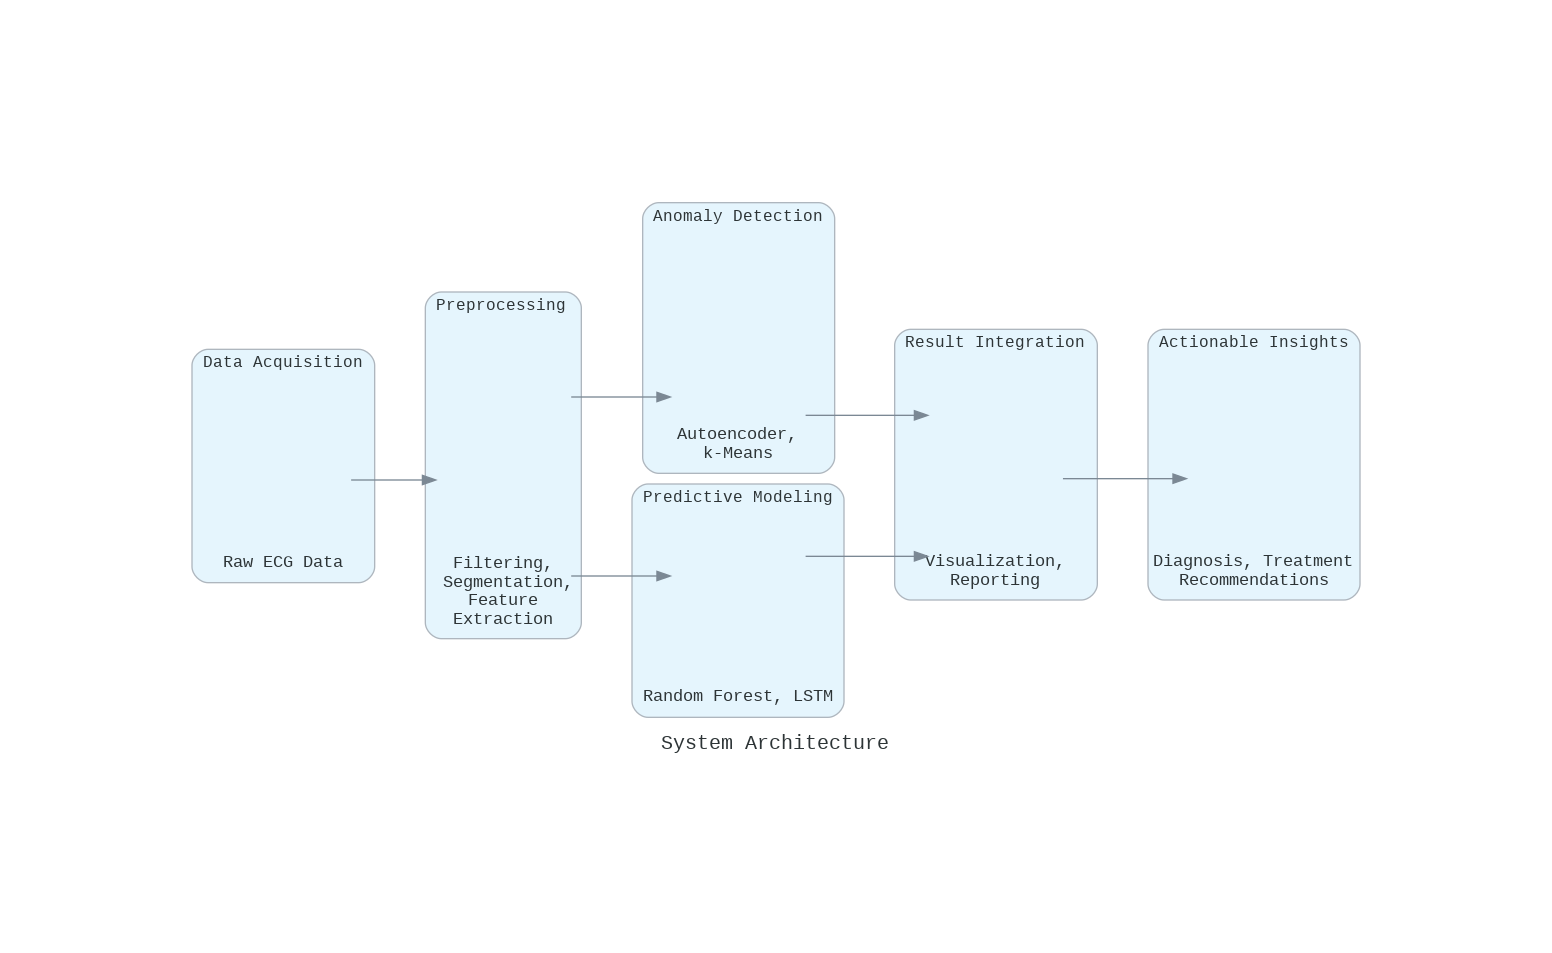

In [ ]:
from diagrams import Cluster, Diagram, Edge
from diagrams.custom import Custom

with Diagram("System Architecture", show=False, filename="system_architecture"):
    with Cluster("Data Acquisition"):
        input_data = Custom("Raw ECG Data", "./ecg_signal.png")

    with Cluster("Preprocessing"):
        preprocessing = Custom("Filtering,\n Segmentation,\nFeature\nExtraction", "./preprocessing.png")

    with Cluster("Anomaly Detection"):
        anomaly_detection = Custom("Autoencoder,\nk-Means", "./anomaly_detection.png")

    with Cluster("Predictive Modeling"):
        predictive_modeling = Custom("Random Forest, LSTM", "./predictive_modeling.png")

    with Cluster("Result Integration"):
        result_integration = Custom("Visualization,\nReporting", "./result_integration.png")

    with Cluster("Actionable Insights"):
        insights = Custom("Diagnosis, Treatment\nRecommendations", "./insights.png")

    input_data >> preprocessing >> anomaly_detection >> result_integration >> insights
    preprocessing >> predictive_modeling >> result_integration


from IPython.display import Image
display(Image('system_architecture.png'))

# Anomaly Detection Workflow (Schema 2)

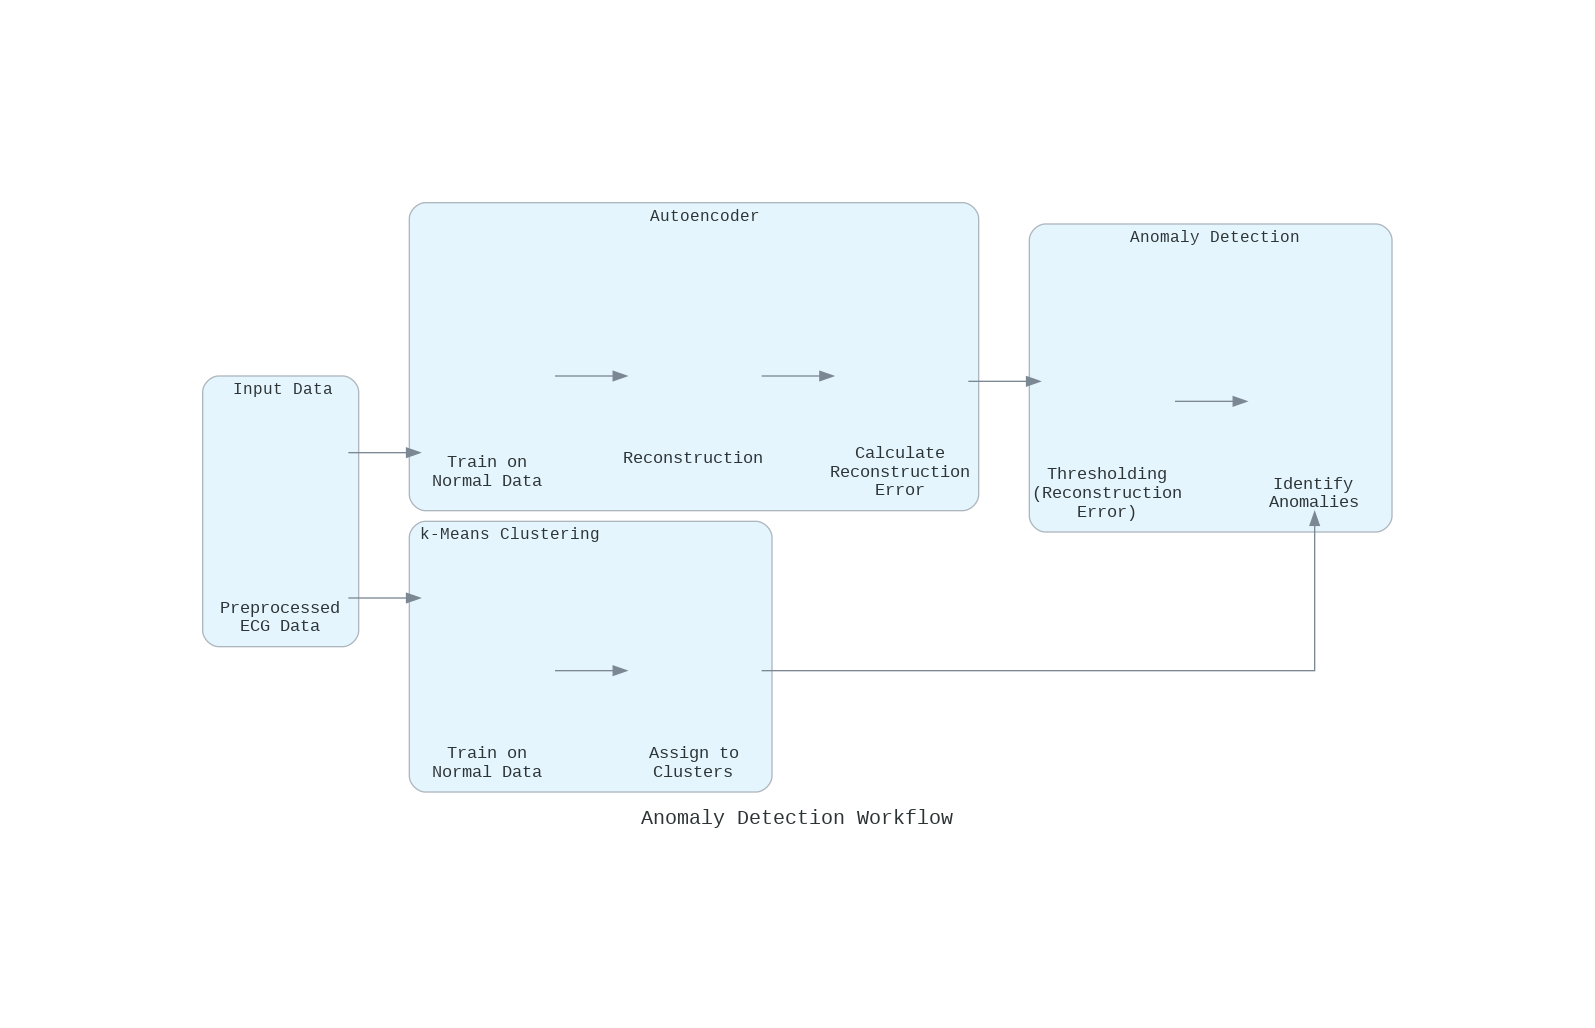

In [ ]:
from diagrams import Cluster, Diagram, Edge
from diagrams.custom import Custom

with Diagram("Anomaly Detection Workflow", show=False, filename="anomaly_detection_workflow"):
    with Cluster("  Input Data"):
        input_data = Custom("Preprocessed\nECG Data", "./ecg_signal.png")

    with Cluster("                       Autoencoder"):
        train_autoencoder = Custom("Train on\nNormal Data", "./training.png")
        reconstruction = Custom("Reconstruction", "./reconstruction.png")
        error_calculation = Custom("Calculate\nReconstruction\nError", "./error.png")

    with Cluster("k-Means Clustering"):
        train_kmeans = Custom("Train on\nNormal Data", "./training.png")
        cluster_assignment = Custom("Assign to\nClusters", "./clustering.png")

    with Cluster("         Anomaly Detection"):
        thresholding = Custom("Thresholding\n(Reconstruction\nError)", "./threshold.png")
        anomaly_identification = Custom("Identify\nAnomalies", "./anomaly.png")

    input_data >> train_autoencoder >> reconstruction >> error_calculation
    input_data >> train_kmeans >> cluster_assignment
    error_calculation >> thresholding >> anomaly_identification
    cluster_assignment >> anomaly_identification

from IPython.display import Image
display(Image('anomaly_detection_workflow.png'))

# Predictive Modeling Workflow (Schema 3)

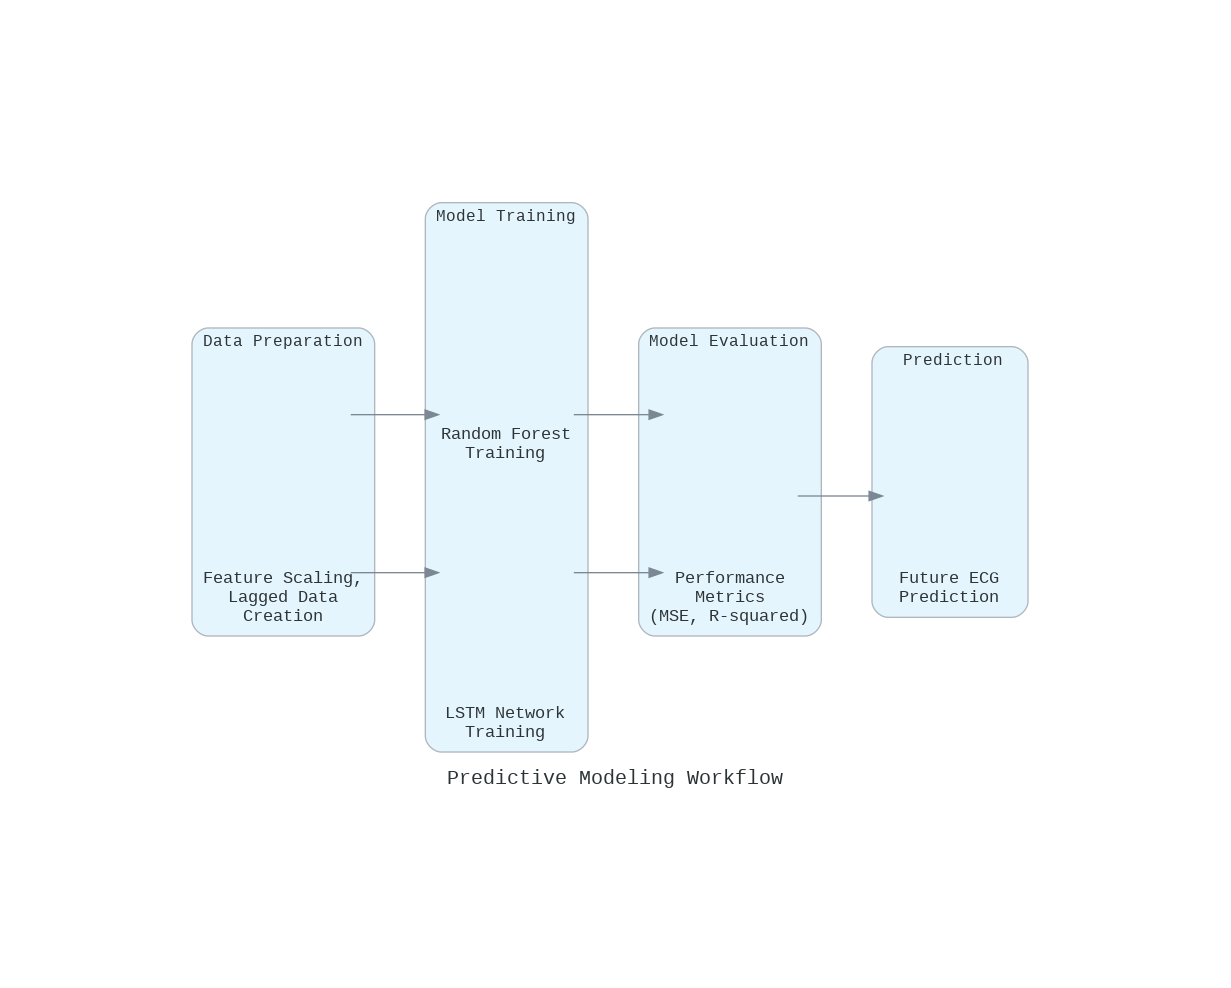

In [ ]:
from diagrams import Cluster, Diagram, Edge
from diagrams.custom import Custom

with Diagram("Predictive Modeling Workflow", show=False, filename="predictive_modeling_workflow_schema3"):
    with Cluster("Data Preparation"):
        data_prep = Custom("Feature Scaling,\nLagged Data\nCreation", "./data_preparation.png")

    with Cluster("Model Training"):
        rf_training = Custom("Random Forest\nTraining", "./random_forest.png")
        lstm_training = Custom("LSTM Network\nTraining", "./lstm.png")

    with Cluster("Model Evaluation"):
        evaluation = Custom("Performance\nMetrics\n(MSE, R-squared)", "./evaluation.png")

    with Cluster("  Prediction"):
        prediction = Custom("Future ECG\nPrediction", "./prediction.png")

    data_prep >> rf_training >> evaluation >> prediction
    data_prep >> lstm_training >> evaluation

from IPython.display import Image
display(Image('predictive_modeling_workflow_schema3.png'))